In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
plt.style.use('ggplot')

In [ ]:
attributes = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')
bboxes = pd.read_csv('/kaggle/input/celeba-dataset/list_bbox_celeba.csv')
partition = pd.read_csv('/kaggle/input/celeba-dataset/list_eval_partition.csv')
landmarks = pd.read_csv('/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv')
base_directory = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

In [ ]:
images_in_row = 10
images_in_column = 7

paths_to_images = [os.path.join(base_directory, filename) 
                   for filename in os.listdir(base_directory)[:images_in_row * images_in_column]]
image = cv2.imread(paths_to_images[0])

height = image.shape[0]
width = image.shape[1]
channels = image.shape[2]


h_stack = np.zeros(shape = (images_in_row, height, width, channels))
images = np.zeros(shape = (images_in_column, height, width * images_in_row, channels))


for iteration in range(images_in_column):

    start = images_in_row * iteration
    end = images_in_row * (iteration + 1)
    
    h_stack = np.zeros(shape = (images_in_row, height, width, channels))
    
    for index, filename in enumerate(paths_to_images[start:end]):
        
        current_image = cv2.imread(filename)
        current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB) / 255
        h_stack[index] = current_image
        
    h_stack = np.hstack(h_stack)
    images[iteration] = h_stack

images = np.concatenate(images)
plt.figure(figsize = (20, 20))
plt.axis('off')
plt.imshow(images)


# let's figure out what all this data mean

okay partition is just recomended parameter of dataset distribution 

In [ ]:
def show_partition(examples):
    types_of_partition = len(np.unique(partition.partition))
    images = np.zeros(shape = (examples, height, width * types_of_partition, channels))
    for iteration in range(examples):
        h_stack = np.zeros(shape = (types_of_partition, height, width, channels))
        for index, cur_partition in enumerate(np.unique(partition.partition)):
            rand = np.random.randint(100)
            current_path = partition.query('partition == {}'.format(cur_partition)).iloc[rand].image_id
            current_path = os.path.join(base_directory, current_path)
            current_image = cv2.imread(current_path) 
            current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)
            h_stack[index] = current_image / 255
        h_stack = np.hstack(h_stack)
        images[iteration] = h_stack
    images = np.concatenate(images)
    
    plt.figure(figsize = (20, 10))
    suptitle = 'partition: 0' + ' ' * 10
    suptitle += 'partition: 1' + ' ' * 10
    suptitle += 'partition: 2' + ' ' * 10
    plt.suptitle(suptitle)
    plt.axis('off')
    plt.imshow(images)
        
        
        
show_partition(examples = 3)

In [ ]:
example_image = cv2.imread(sorted(paths_to_images)[0])
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

original_image = example_image.copy()

current_landmarks = landmarks.query('image_id == "{}"'.format(paths_to_images[1].split('/')[-1]))
eye_x, eye_y, eye_w, eye_h = np.array(landmarks.iloc[:, 1:5])[0]
nose_x,	nose_y,	leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y = np.array(landmarks.iloc[:, 5:])[0]

left_eye = (eye_x, eye_y)
right_eye = (eye_w, eye_h)
nose = (nose_x + 10,	nose_y)
left_mounth = (leftmouth_x, leftmouth_y)
right_mounth = (rightmouth_x, rightmouth_y)

current_bbox = bboxes.query('image_id == "{}"'.format(paths_to_images[1].split('/')[-1]))
x, y, w, h = np.array(current_bbox.iloc[:, 1:])[0]

example_image = cv2.rectangle(example_image, (x - w, y ), (w , h ), (0, 255, 255), 1)

example_image = cv2.line(example_image, left_eye, right_eye, (0, 255, 255),1)
example_image = cv2.line(example_image, left_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, right_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, nose, left_mounth,(0, 255, 255), 1)
example_image = cv2.line(example_image, nose, right_mounth, (0, 255, 255), 1)

plt.figure(figsize = (10, 20))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('with bbox and landmarks')
plt.imshow(example_image)

In [ ]:
train_images = partition.query('partition == 0')
valid_images = partition.query('partition == 1')
test_images = partition.query('partition == 2')

In [ ]:
def relu(a):
    if type(a) != str:
        a = (a > 0) * a
    return a

attributes.iloc[:, 1:] = attributes.iloc[:, 1:].apply(lambda a: relu(a))

In [ ]:
train_data = train_images.merge(attributes, how = 'inner').drop(['partition'], axis = 1)
valid_data = valid_images.merge(attributes, how = 'inner').drop(['partition'], axis = 1)
test_data = test_images.merge(attributes, how = 'inner').drop(['partition'], axis = 1)

In [ ]:
train_data

In [ ]:
def create_batch(data, iteration, batch_size):
    '''
    this function create batch of images as labels 
    for each iteration during training
    
    Arguments:
        data(dataframe): DataFrame with labels and paths to images
        iteration(int): current iteration
        batch_size(int): number of images in one batch
    Returns:
        batch of data
    '''
    start = iteration * batch_size
    end = batch_size * (iteration + 1)
    current_data = data.iloc[start:end]
    
    num_features = 23
    
    images = np.zeros(shape = (batch_size, image_size, image_size, channels))
#     here 23 features
    is_hairs = np.zeros(shape = (batch_size, 2))
    hairs_type = np.zeros(shape = (batch_size, 2))
    hair_colors = np.zeros(shape = (batch_size, 4))
    hairs_on_face = np.zeros(shape = (batch_size, 4))
    gender = np.zeros(shape = (batch_size, 2))
    mimics = np.zeros(shape = (batch_size, 2))
    face_form = np.zeros(shape = (batch_size, 2))
    young = np.zeros(shape = (batch_size, 2))
    skin = np.zeros(shape = (batch_size, 2))
    attractive = np.zeros(shape = (batch_size, 2))
    nose = np.zeros(shape = (batch_size, 2))
    eyes = np.zeros(shape = (batch_size, 2))
    cheekbones = np.zeros(shape = (batch_size, 2))
    eyebrows = np.zeros(shape = (batch_size, 2))
    chin = np.zeros(shape = (batch_size, 2))
    lips = np.zeros(shape = (batch_size, 2))
    makeup = np.zeros(shape = (batch_size, 2))
    hat = np.zeros(shape = (batch_size, 2))
    necktie = np.zeros(shape = (batch_size, 2))
    earrings = np.zeros(shape = (batch_size, 2))
    necklace = np.zeros(shape = (batch_size, 2))
    necktie = np.zeros(shape = (batch_size, 2))
    effects = np.zeros(shape = (batch_size, 2))
    
   
    for index in range(batch_size):
        
#         load and preprocess image
        current_image_path = os.path.join(base_directory, current_data['image_id'].iloc[index])
        current_image = load_img(current_image_path).resize((image_size, image_size))
        
#         z_codes == features
        five_o_Clock_Shadow = current_data['5_o_Clock_Shadow'].iloc[index]
        Arched_Eyebrows     = current_data['Arched_Eyebrows'].iloc[index]
        Attractive          = current_data['Attractive'].iloc[index]
        Bags_Under_Eyes     = current_data['Bags_Under_Eyes'].iloc[index]
        Bald                = current_data['Bald'].iloc[index]
        Bangs               = current_data['Bangs'].iloc[index]
        Big_Lips            = current_data['Big_Lips'].iloc[index]
        Big_Nose            = current_data['Big_Nose'].iloc[index]
        Black_Hair          = current_data['Black_Hair'].iloc[index]
        Blond_Hair          = current_data['Blond_Hair'].iloc[index]
        Blurry              = current_data['Blurry'].iloc[index]
        Brown_Hair          = current_data['Brown_Hair'].iloc[index]
        Bushy_Eyebrows      = current_data['Bushy_Eyebrows'].iloc[index]
        Chubby              = current_data['Chubby'].iloc[index]
        Double_Chin         = current_data['Double_Chin'].iloc[index]
        Eyeglasses          = current_data['Eyeglasses'].iloc[index]
        Goatee              = current_data['Goatee'].iloc[index]
        Gray_Hair           = current_data['Gray_Hair'].iloc[index]
        Heavy_Makeup        = current_data['Heavy_Makeup'].iloc[index]
        High_Cheekbones     = current_data['High_Cheekbones'].iloc[index]
        Male                = current_data['Male'].iloc[index]
        Mouth_Slightly_Open = current_data['Mouth_Slightly_Open'].iloc[index]
        Mustache            = current_data['Mustache'].iloc[index]
        Narrow_Eyes         = current_data['Narrow_Eyes'].iloc[index]
        No_Beard            = current_data['No_Beard'].iloc[index]
        Oval_Face           = current_data['Oval_Face'].iloc[index]
        Pale_Skin           = current_data['Pale_Skin'].iloc[index]
        Pointy_Nose         = current_data['Pointy_Nose'].iloc[index]
        Receding_Hairline   = current_data['Receding_Hairline'].iloc[index]
        Rosy_Cheeks         = current_data['Rosy_Cheeks'].iloc[index]
        Sideburns           = current_data['Sideburns'].iloc[index]
        Smiling             = current_data['Smiling'].iloc[index]
        Straight_Hair       = current_data['Straight_Hair'].iloc[index]
        Wavy_Hair           = current_data['Wavy_Hair'].iloc[index]
        Wearing_Earrings    = current_data['Wearing_Earrings'].iloc[index]
        Wearing_Hat         = current_data['Wearing_Hat'].iloc[index]
        Wearing_Lipstick    = current_data['Wearing_Lipstick'].iloc[index]
        Wearing_Necklace    = current_data['Wearing_Necklace'].iloc[index]
        Wearing_Necktie     = current_data['Wearing_Necktie'].iloc[index]
        Young               = current_data['Young'].iloc[index]
        
#         one image from batch
        images[index] = current_image
    
#         z-codes
        is_hairs[index] = [Bald, Bangs]
        hairs_type[index] = [Wavy_Hair, Straight_Hair] 
        hair_colors[index] = [Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair]
        hairs_on_face[index] = [Goatee, Mustache, No_Beard, Sideburns, ]
        gender[index] = [Male, 1 - Male]
        mimics[index] = [Smiling, Mouth_Slightly_Open,]
        face_form[index] = [Oval_Face, Chubby]
        young[index] = [Young, 1 - Young]
        skin[index] = [Pale_Skin, 1- Pale_Skin]
        attractive[index] = [Attractive, 1 - Attractive]
        nose[index] = [Big_Nose, Pointy_Nose]
        eyes[index] = [Narrow_Eyes, Bags_Under_Eyes,]
        cheekbones[index] = [High_Cheekbones, Rosy_Cheeks]
        eyebrows[index] = [Arched_Eyebrows, Bushy_Eyebrows]
        chin[index] = [Double_Chin, 1 - Double_Chin]
        lips[index] = [Big_Lips, Wearing_Lipstick]
        makeup[index] = [Heavy_Makeup, 1 - Heavy_Makeup]
        hat[index] = [Wearing_Hat, 1- Wearing_Hat]
        necktie[index] = [Wearing_Necktie, 1- Wearing_Necktie]
        earrings[index] = [Wearing_Earrings, 1 - Wearing_Earrings]
        necklace[index] = [Wearing_Necklace, 1 - Wearing_Necklace]
        necktie[index] = [Wearing_Necktie, 1 - Wearing_Necktie]
        effects[index] = [Blurry, five_o_Clock_Shadow]
        
        
    z_codes = dict()    
#     z_codes
    z_codes['is_hairs'] = is_hairs
    z_codes['hairs_type'] = hairs_type
    z_codes['hair_colors'] = hair_colors 
    z_codes['hairs_on_face'] = hairs_on_face
    z_codes['gender'] = gender
    z_codes['mimics'] = mimics 
    z_codes['face_form'] = face_form 
    z_codes['young'] = young 
    z_codes['skin'] = skin
    z_codes['attractive'] = attractive
    z_codes['nose'] = nose 
    z_codes['eyes'] = eyes 
    z_codes['cheekbones'] = cheekbones 
    z_codes['eyebrows'] = eyebrows 
    z_codes['chin'] = chin 
    z_codes['lips'] = lips 
    z_codes['makeup'] = makeup
    z_codes['hat'] = hat
    z_codes['necktie'] = necktie 
    z_codes['earrings'] = earrings
    z_codes['necklace'] = necklace
    z_codes['necktie'] = necktie 
    z_codes['effects'] = effects 
    
    
    images /= 255
    
    return images, z_codes

image_size = 128   

batch_size = 20
train_images, train_z_codes = create_batch(data = train_data, iteration = 0, batch_size = batch_size)

# Model Architecture

# encoder

In [ ]:
def build_encoder(input_shape, name):
    '''
    This function builds a lightweight encoder
    
    Arguments:
        input_shape(tuple): input images shape
        name (str): the name of the feature the generator 
        is responsible for generating
        
        name must be in z_codes dictionary
    '''
    
    output_shape = train_z_codes[name].shape[1]
    
    last_activation = 'sigmoid'
    optimizer = Adam(lr = 0.001)
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    if output_shape > 2:
        last_activation = 'softmax'
        loss = 'categorical_crossentropy'
    
    inputs = Input(shape = input_shape)
    
    x = inputs   
    
    x = SeparableConv2D(filters = 128, 
                        kernel_size = 3, 
                        activation = 'relu', 
                        name = 'block_1')(x)
    x = MaxPooling2D(2)(x)
    x = BatchNormalization()(x)
    
    x = SeparableConv2D(filters = 64, 
                        kernel_size = 3, 
                        activation = 'relu', 
                        name = 'block_2')(x)
    x = MaxPooling2D(2)(x)
    x = BatchNormalization()(x)
    
    x = SeparableConv2D(filters = 32, 
                        kernel_size = 3, 
                        activation = 'relu', 
                        name = 'block_3')(x)
    x = MaxPooling2D(2)(x)
    x = BatchNormalization()(x)
    
    x = SeparableConv2D(filters = 16, 
                        kernel_size = 3, 
                        activation = 'relu', 
                        name = 'block_4')(x)
    x = MaxPooling2D(2)(x)
    x = BatchNormalization()(x)
    
    x = Flatten(name = 'Flatten')(x)
    x = Dropout(0.3, name = 'Dropout')(x)
    
    outputs = Dense(output_shape, 
                    activation = last_activation)(x)
    
    encoder = Model(inputs = inputs, 
                    outputs = outputs, 
                    name = f'{name}_encoder')
    
    encoder.compile(optimizer = optimizer, 
                    loss = loss, 
                    metrics = metrics)
    
    return encoder
                                       
    
input_shape = (image_size, image_size, channels)
name = 'hair_colors'
encoder = build_encoder(input_shape = input_shape, name = name) 

In [ ]:
plot_model(encoder, show_shapes = True, to_file = 'encoder_model.png')

GAN = generator + discriminator

# Generator

In [ ]:
def build_generator(z_codes_shape, image_size, name):
    '''
    description:
        this function creates a generator
        each generator responds
        for the feature it should generate
    
    Arguments:
        inputs(tensor): batch of images and corresponds z_codes
        image_size(tuple) tuple with input image parameters
        name(str): the name of the feature the generator 
        is responsible for generating
        
        name must be in z_codes dictionary
        
    Returns:
        Generator model
    '''
    
    
#     network parameters
    layer_filters = [512, 128, 64, 3]
    kernel_size = 5
    strides = 2    
    
    channels = 3
    latent_shape = 100
    image_resize = image_size // len(layer_filters)
    noise_input_shape = (image_size, image_size, channels)

    
    noise_shape = (image_size, image_size, channels)
    
    noise_input = Input(shape = noise_shape, name = 'noise_input')
    noise_branch = Reshape(target_shape = (128 * 128 * 3, ),
                           name = 'noise_flatten')(noise_input)
    noise_branch = Dense(units = latent_shape, 
                         activation = 'relu',
                         name = 'latent')(noise_branch)
    
    z_codes_input = Input(shape = z_codes_shape, name = 'z_codes_input')
    
    two_inputs = [noise_input, z_codes_input]
    inputs = concatenate([noise_branch, z_codes_input], 
                         name = 'concatenate_layer')
    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape(target_shape = (image_resize, image_resize, layer_filters[0]))(x)
    
    for index, filters in enumerate(layer_filters):
        if filters == layer_filters[-2]:
            strides = 1
            
        x = BatchNormalization(name = f'BN_block_{index}')(x)
        x = LeakyReLU(alpha = 0.2,
                     name = f'Leaky_block_{index}')(x)
        
        x = Conv2DTranspose(filters = filters, 
                            kernel_size = kernel_size,
                            strides = strides,
                            padding = 'same',
                            name = f'block_{index}')(x)
    outputs = Activation(activation = 'tanh', 
                         name = 'generator_output')(x)
    
    generator = Model(inputs = two_inputs, outputs = outputs, name = f'{name}_generator')
    
    loss = 'binary_crossentropy'
    optimizer = Adam(lr = 0.01)
    metrics = ['accuracy']
    generator.compile(loss = loss, optimizer = optimizer, metrics = metrics)
    
    return generator
        
    
name = 'gender'
noise = np.random.random(size = (batch_size, 128, 128, 3))
labels = train_z_codes[name]
inputs = [noise, labels]
generator_1 = build_generator(labels.shape[1], 
                              image_size = train_images.shape[1], 
                              name = name)

In [ ]:
plot_model(generator_1, show_shapes = True, to_file = 'generator_model.png')

# Discriminator

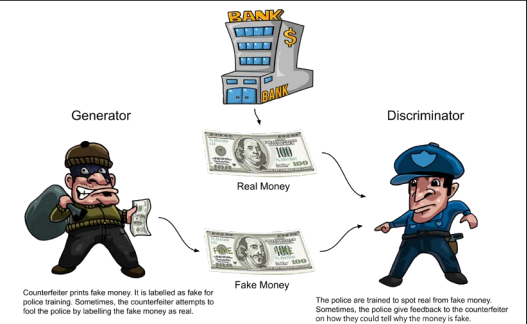

In [ ]:
def build_discriminator(input_shape):
    
    inputs = Input(shape = input_shape)
    x = inputs
    blocks_count = 4
    layers_filters = [128, 64, 32,]
    
    for index, filters in enumerate(layers_filters):
        x = SeparableConv2D(filters = filters , 
                            kernel_size = 3,
                            activation = 'relu', 
                            name = f'block_{index}')(x)
        
        x = MaxPooling2D(pool_size = 2)(x)
        x = BatchNormalization()(x)
    
    x = Flatten(name = 'flatten')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(1, activation = 'sigmoid')(x)
    
    discriminator_model = Model(inputs = inputs, 
                          outputs = outputs,
                          name = 'discriminator'
                         )
    
    optimizer = Adam(lr = 0.01)
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    discriminator_model.compile(optimizer = optimizer,
                                loss = loss,
                                metrics = metrics,
                               )
    return discriminator_model

discriminator = build_discriminator(input_shape = input_shape)

In [ ]:
plot_model(discriminator, show_shapes = True, to_file = 'discriminator_model.png')

# StackedGAN

GAN: adversarial = discriminator(generator)

# this model architecture

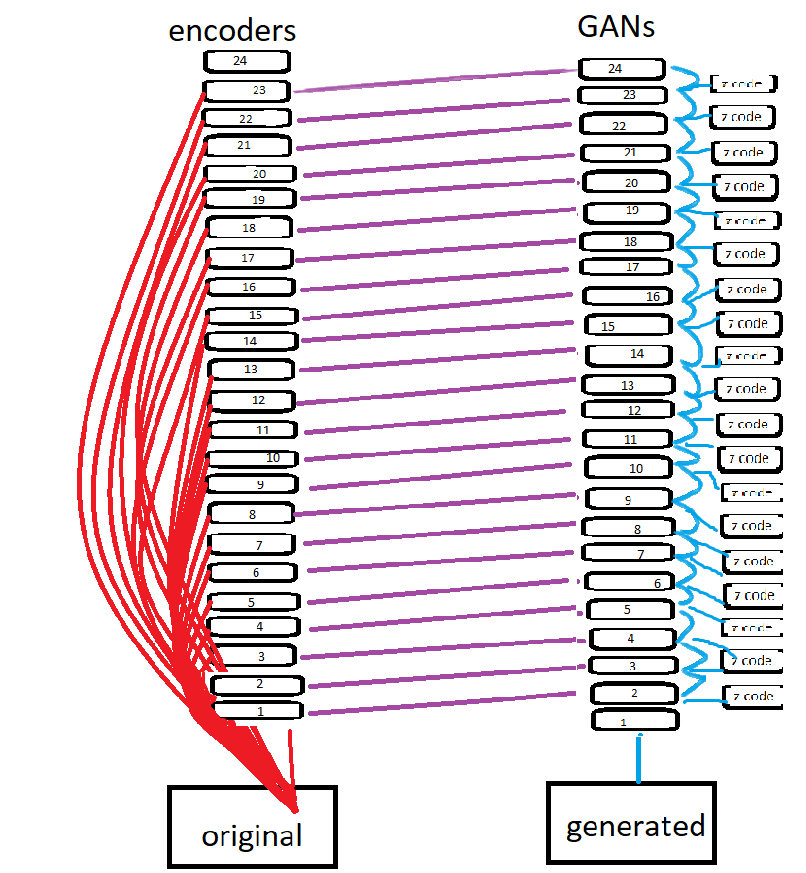

In [ ]:
!nvidia-smi

In [ ]:
    def train_stack(epoch,
                    previous_generator_output,
                    train_labels,
                    train_images,
                    encoder,
                    generator,
                    discriminator):
        images_directory = '/kaggle/working/generated_images'
        if os.path.isdir(images_directory) == False:
            os.mkdir(images_directory)
    
        name_index = generator.name.index('_generator')
        name = generator.name[:name_index]

        current_train_labels = train_labels[name]
        # train encoder         
        train_loss, train_accuracy = encoder.train_on_batch(x = train_images,
                                                            y = current_train_labels)

        print(f'{name}_Encoder --> epoch: {epoch} --> loss: {train_loss}, accuracy: {train_accuracy}')

        encoder_output = encoder.predict(train_images)

        # train generator         
        train_loss, train_accuracy = generator.train_on_batch(x = [previous_generator_output, 
                                                                   encoder_output], 
                                                              y = train_images)
        print(f'{name}_generator --> epoch: {epoch} --> loss: {train_loss},accuracy: {train_accuracy}')

        generator_output = generator.predict([previous_generator_output, current_train_labels])
        predict = cv2.cvtColor(generator_output[0], cv2.COLOR_RGB2BGR) * 255

        if epoch % 5  == 0:
            generated_path = os.path.join(images_directory, f'epoch_{epoch}_.jpg')
            cv2.imwrite(generated_path, predict)
        # train discriminator
        # discriminator decide original this image or fake
        # for this we it need to have train and fake images
        # for training. let's help to discriminator

        # generated images and labels
        fake_images = generator_output
        fake_labels = np.zeros(shape = batch_size)
        
        # original images and labels from train dataset
        original_images = train_images
        original_labels = np.ones(shape = batch_size)

        rand_indexes = np.random.shuffle(np.arange(batch_size * 2))

        #  mix train_data
        real_fake_images = np.concatenate([fake_images, original_images])[rand_indexes]
        real_fake_labels = np.concatenate([fake_labels, original_labels])[rand_indexes]

        real_fake_images = real_fake_images.reshape((real_fake_images.shape[1:]))
        real_fake_labels = real_fake_labels.reshape((real_fake_labels.shape[1:]))
        # train discriminator
        train_loss, train_accuracy = discriminator.train_on_batch(x = real_fake_images, 
                                                                 y = real_fake_labels)

        print(f'{name}_discriminator --> epoch: {epoch} --> loss: {train_loss}, accuracy: {train_accuracy}')

        discriminator_output = discriminator.predict(generator_output)

        return generator_output

In [ ]:
def train_and_build_StackedGAN(train_data,
                               batch_size, 
                               epochs):
    
#     this small batch just for parameters setting
    train_images, train_labels = create_batch(data = train_data, 
                                              iteration = 0, 
                                              batch_size = batch_size)   
    #  parameters
    image_size = train_images.shape[1]
    channels = train_images.shape[3]
    noise = np.random.normal(size = train_images.shape)
    input_shape = (image_size, image_size, channels)
    
#     code below create discriminators, generators and encoders
#     which number equal number of z_codes in discrionary
    encoders = [build_encoder(input_shape = input_shape, name = name) for name in names]
    
    generators = [build_generator(name = name, 
                                  z_codes_shape = train_labels[name].shape[1], 
                                  image_size = image_size) for name in names]
    
    discriminators = [build_discriminator(input_shape = input_shape) for name in names]
        
#         training process
    generator_output = noise
    
    for epoch in range(epochs):
        print('-'* 10 + f'epoch: {epoch}' + 10*'-')
        
        # data
        train_images, train_labels = create_batch(data = train_data, 
                                                  iteration = epoch, 
                                                  batch_size = batch_size)

        # model architecture and training
        for index in range(len(generators)):
        
            generator_output = train_stack(epoch = epoch,
                                           train_labels = train_labels,
                                           train_images = train_images,
                                           previous_generator_output = generator_output,
                                           encoder = encoders[index], 
                                           generator = generators[index], 
                                           discriminator = discriminators[index])
      
        
epochs = 100
batch_size = 128
names = list(train_z_codes)
train_and_build_StackedGAN(train_data = train_data,
                           batch_size = batch_size, 
                           epochs = epochs)